<a href="https://colab.research.google.com/github/blueeagle100/think_autonomous/blob/main/kalman_filters_course/track_bicycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project for Think Autonoumous Kalman Filters Course

### First download required packages and get folder structure from Google Drive

In [ ]:
!pip install yolo5 # version 0.0.1 used at the moment of recording

In [ ]:
!pip install Pillow==7.1.2

In [2]:
# get model weights

!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install
!ls

Cloning into 'yolov5'...
remote: Enumerating objects: 12447, done.
remote: Total 12447 (delta 0), reused 0 (delta 0), pack-reused 12447
Receiving objects: 100% (12447/12447), 12.15 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (8591/8591), done.
/content/yolov5
CONTRIBUTING.md  export.py   models	       setup.cfg       utils
data		 hubconf.py  README.md	       train.py        val.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/think_autonomous/kalman_filters_course")
!ls

Mounted at /content/drive
'Designing a Kalman Filter.ipynb'	    __pycache__
'Designing a Kalman Filter Starter.ipynb'   README.md
 Final_Project.ipynb			    track.mp4
 Final_Project_Starter.ipynb		    yolo_for_tracking_2.py
 images					    yolov5
 Probabilities.ipynb			    yolov5s.pt


In [4]:
import yolov5

# load model
model = yolov5.load('yolov5/models/yolov5s.pt')

In [5]:
model.conf = 0.35 # 0.5
model.iou = 0.4

In [7]:
import time
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### Get MSCOCO classes

In [8]:
fp = r'yolov5/data/coco128.yaml'

with open(fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = {i : name for i, name in enumerate(coco_info['names'])}

#### Helper functions

In [9]:
def id_to_color(idx):
    """
    Random function to convert an id to a color
    (keep numbers below 255)
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

def draw_boxes_v5(image_in, boxes, categories, mot_mode=False):
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        color = id_to_color(i*10) if mot_mode==True else (255,0,60)
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=3)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=3)
    return image

def inference(img, draw_boxes=True):
    results = model(img)
    predictions = results.pred[0]
    boxes = predictions[:, :4].tolist()
    boxes_int = [[int(v) for v in box] for box in boxes]
    scores = predictions[:,4].tolist()
    categories = predictions[:,5].tolist()
    categories_int = [int(c) for c in categories]
    
    if draw_boxes:
      img_out = draw_boxes_v5(img, boxes_int, categories_int, mot_mode=False)
    else:
      img_out = img.copy()

    # change everything to arrays
    boxes_int = np.array(boxes_int)
    categories_int = np.array(categories_int)
    scores = np.array(scores)
    return img_out, boxes_int, categories_int, scores

## Get Bicycle bounding boxes and X-Y location in each frame

In [61]:
# trim video if trimmed video not in direcotry
from moviepy.editor import VideoFileClip
# from google.colab.patches import cv2_imshow

video_path = r'images/VIRAT_S_010204_09_001285_001336.mp4'
clip = VideoFileClip(video_path).subclip(15,25)

clip.write_videofile(r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2023424/45929032 bytes (4.4%)4866048/45929032 bytes (10.6%)7421952/45929032 bytes (16.2%)10395648/45929032 bytes (22.6%)13451264/45929032 bytes (29.3%)16474112/45929032 bytes (35.9%)19365888/45929032 bytes (42.2%)22069248/45929032 bytes (48.1%)24895488/45929032 bytes (54.2%)27721728/45929032 bytes (60.4%)30703616/45929032 bytes (66.9%)33546240/45929032 bytes (73.0%)

100%|██████████| 240/240 [00:08<00:00, 27.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4 



In [20]:
video_path = r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4'

# store some outputs in lists
output_frames = []
BICYCLE_MEASUREMENTS = []
TIMESTAMPS = []

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # prepare frame for model input
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_out, boxes_int, categories_int, scores = inference(frame, draw_boxes=False)
    
    # update time stamps
    TIMESTAMPS.append(time.time())

    # if a Bicycle was detected draw boxes
    if 1 in categories_int:
        bicycle_locs = categories_int == 1
        boxes = boxes_int[bicycle_locs]
        cats = categories_int[bicycle_locs]

        # draw bicycle bounding box
        boxed_image = draw_boxes_v5(img_out, boxes, cats, mot_mode=True)
        output_frames.append(boxed_image)
        
        # update bicycle location
        x1, y1 = boxes[0][0], boxes[0][1]
        x2, y2 = boxes[0][2], boxes[0][3]
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2
        BICYCLE_MEASUREMENTS.append([x, y])

    # else add not detected string
    else:
        BICYCLE_MEASUREMENTS.append("Not detected")
        output_frames.append(img_out)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


In [21]:
BICYCLE_MEASUREMENTS

['Not detected',
 [274.5, 321.5],
 [278.0, 322.5],
 [291.0, 318.0],
 [292.5, 319.5],
 [292.5, 321.5],
 [294.0, 322.0],
 [301.5, 323.0],
 [304.0, 324.5],
 [306.0, 325.0],
 [308.0, 324.5],
 [311.5, 322.5],
 [315.5, 323.0],
 [322.5, 321.0],
 [325.5, 325.0],
 [329.5, 325.5],
 [335.5, 325.5],
 [337.5, 326.5],
 [341.0, 324.5],
 [347.5, 327.0],
 [350.0, 329.5],
 [351.0, 329.5],
 [355.5, 326.0],
 [359.5, 324.5],
 [363.0, 323.0],
 [365.5, 323.0],
 [367.0, 323.5],
 [368.0, 324.0],
 [372.5, 323.5],
 [375.0, 324.5],
 [379.0, 324.5],
 [380.0, 323.0],
 [385.5, 328.5],
 [386.0, 328.0],
 [387.5, 326.5],
 [388.5, 325.5],
 [392.5, 324.0],
 [394.0, 324.0],
 [395.5, 324.0],
 [396.5, 325.5],
 [401.5, 329.5],
 [402.5, 331.0],
 [403.0, 330.0],
 [406.5, 329.5],
 [409.0, 332.0],
 [410.5, 331.5],
 [412.0, 332.5],
 [414.5, 337.0],
 [418.5, 336.5],
 [419.5, 336.0],
 [421.5, 335.0],
 [423.5, 335.5],
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected',
 'Not detected

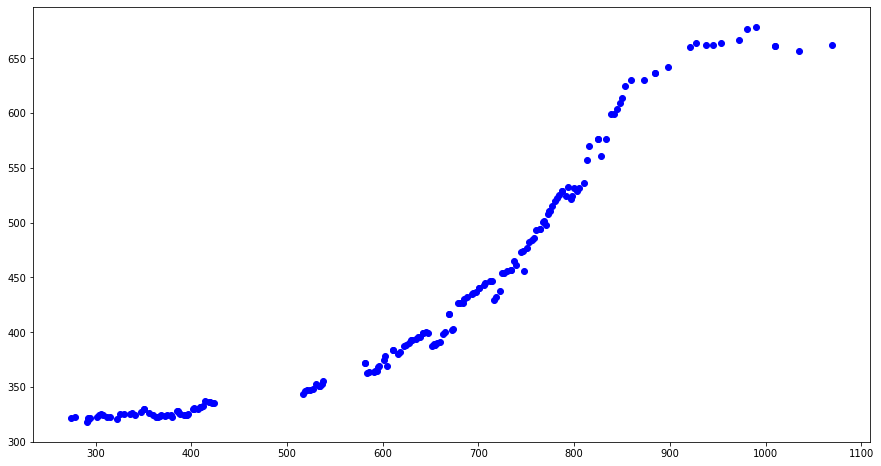

In [22]:
# just for fun, plot the bicycle path!

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for xy in BICYCLE_MEASUREMENTS:
    if not isinstance(xy, str):
        ax.scatter(xy[0], xy[1], marker='o', color='b')

In [23]:
from tqdm import tqdm

result_video = []

for img in tqdm(output_frames):
    result_video.append(img)

100%|██████████| 240/240 [00:00<00:00, 794501.15it/s]


In [24]:
out = cv2.VideoWriter('images/BICYCLE_DETECT_0.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (img.shape[1],img.shape[0]))

for img in result_video:
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

## Get Kalman Filter to track Bicycle

In [25]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 21.7 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=c14dbcce0c213a6ac5779dd796fd931047d984956455b327b01bd8ba0baf61c0
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [26]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt


def TwoDimensionsKF(R_std, Q_std, dt, w, h):
    ''' creates and instantiates a filterpy 2D Kalman Filter object
        with a 2D constant acceleration model
        Inputs:
            R_Std (float) - measurement uncertainty
            Q_std (float) - Proccess noise covariance
            dt (float) - System Time Step
            w (int) - Frame Width
            h (int) - Frame Height
        Outputs:
            kf (filterpy object) 2D Kalman Filter object
    '''
    kf = KalmanFilter(dim_x=6, dim_z=2)
    kf.x = np.array([w//2, h//2, 0.1, 0.1, 0, 0]) # initial state (center of frame)
    kf.P = np.eye(6)*np.max([w//2, h//2])
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q) # Process noise covariance
    kf.R = np.eye(2) * R_std # measurement uncertainty/noise
    kf.H = np.array([[1, 0, 0, 0, 0, 0],  # measurement function
                     [0, 1, 0, 0, 0, 0]])
    kf.F = np.array([[1, 0, dt, 0, 0.5*dt*dt, 0],     # state transition matrix
                     [0, 1, 0,  dt, 0,        0.5*dt*dt],
                     [0, 0, 1,  0,  dt,       0],
                     [0, 0, 0,  1,  0,        dt],
                     [0, 0, 0,  0,  1,        0],
                     [0, 0, 0,  0,  0,        1]])

    return kf

In [231]:
R_std = 15 # 5 # measurement uncertainty
Q_std = 1. # 1.5 # process noise
dt = np.mean(np.diff(TIMESTAMPS)) # time delta

R_std = 7.5 # measurement uncertainty
Q_std = 0.75 # process noise
dt = np.mean(np.diff(TIMESTAMPS)) # time delta

# R_std = 20 # measurement uncertainty
# Q_std = 0.2 # process noise
# dt = 0.75 # time delta


# frame width and height
w, h = 1280, 720

# initialize Kalman Filter
kf = TwoDimensionsKF(R_std, Q_std, dt, w, h)

# store values in lists
updates = [] # estimates from measurement updates
preds = [] # estimates from predictions

# iterate through the measurements
for xy in BICYCLE_MEASUREMENTS:
    # Predict next state
    kf.predict()

    # update state with new measurement
    if not isinstance(xy, str):
       kf.update(xy)
       updates.append(kf.x)
    
    # else:
      # append prediction if measurment not taken
    preds.append(kf.x)

    # print(np.round(kf.P[0,0]))

In [232]:
updates_arr = np.array(updates)
preds_arr = np.array(preds)
pos_updates = updates_arr[:, :2]
pos_preds = preds_arr[:, :2]

print(updates_arr.shape)
print(preds_arr.shape)

(184, 6)
(240, 6)


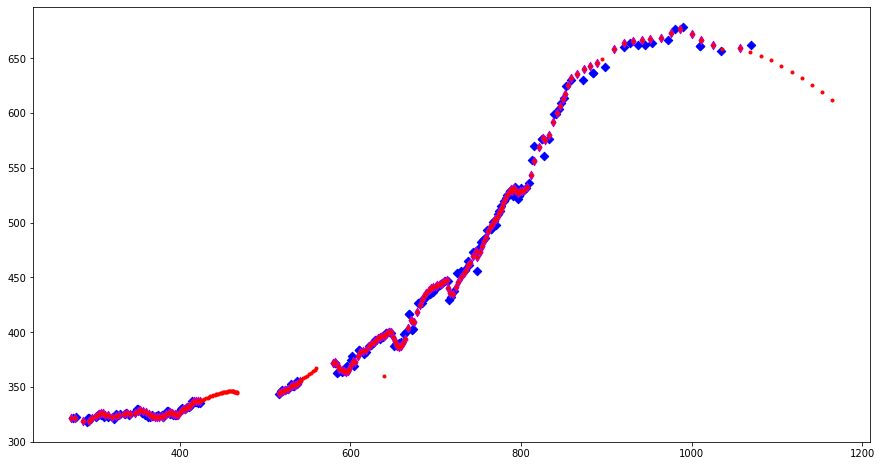

In [233]:
fig = plt.figure(figsize=(15, 8))
for xy in BICYCLE_MEASUREMENTS:
  if not isinstance(xy, str):
    plt.scatter(xy[0], xy[1], marker='D', color='b')

plt.scatter(pos_updates[:, 0], pos_updates[:, 1], marker='d', color='m')
plt.scatter(pos_preds[:, 0], pos_preds[:, 1], marker='.', color='r')

In [234]:
pos_preds[:20]

array([[     640.03,      360.03],
       [      277.7,      321.84],
       [     272.91,       321.9],
       [     286.68,       318.6],
       [     293.79,      318.78],
       [     296.25,      320.69],
       [     297.33,      322.08],
       [     302.22,       323.4],
       [     305.62,      324.94],
       [     307.98,      325.91],
       [     309.86,      325.98],
       [     312.41,      324.71],
       [     315.63,      324.12],
       [      320.8,      322.65],
       [     325.15,      323.65],
       [     329.45,      324.55],
       [      334.6,      325.13],
       [     338.53,      325.93],
       [     342.25,      325.56],
       [     347.09,      326.34]])

In [235]:
R_std = 25   # measurement uncertainty
Q_std = 0.35 # process noise
dt = 0.5     # time delta

# frame width and height
w, h = 1280, 720

# initialize Kalman Filter
kf = TwoDimensionsKF(R_std, Q_std, dt, w, h)

def main_pipeline(image):
    # Predict next state
    kf.predict()

    # prepare frame for model input
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_out, boxes_int, categories_int, scores = inference(image, draw_boxes=False)

    # if a Bicycle was detected draw boxes
    if 1 in categories_int:
        bicycle_locs = categories_int == 1
        boxes = boxes_int[bicycle_locs]
        cats = categories_int[bicycle_locs]

        # draw bicycle bounding box
        img_out = draw_boxes_v5(img_out, boxes, cats, mot_mode=True)
        
        # update bicycle location
        x1, y1 = boxes[0][0], boxes[0][1]
        x2, y2 = boxes[0][2], boxes[0][3]
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2

        # update state based on new measurement
        kf.update(np.array([x, y]))

    # draw new estimate point on image
    x_est, y_est = int(np.round(kf.x[0])), int(np.round(kf.x[1]))
    cv2.circle(img_out, (x_est, y_est), 5, (0, 255, 0), -1)

    return img_out



In [236]:
from moviepy.editor import VideoFileClip
# video_file = "/content/drive/My Drive/think_autonomous/kalman_filters_course/images/detect.mp4"
video_path = r'images/VIRAT_S_010204_09_001285_001336_BICYCLE_TRIM.mp4'
clip = VideoFileClip(video_path)
tracked_clip = clip.fl_image(main_pipeline)
%time tracked_clip.write_videofile("/content/drive/My Drive/think_autonomous/kalman_filters_course/images/track2.mp4",audio=False)

[MoviePy] >>>> Building video /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track2.mp4
[MoviePy] Writing video /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track2.mp4


100%|█████████▉| 240/241 [01:08<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/think_autonomous/kalman_filters_course/images/track2.mp4 

CPU times: user 1min 4s, sys: 16.2 s, total: 1min 20s
Wall time: 1min 9s
